In [1]:

%load_ext autoreload
%autoreload 2

from ETL import *
from yahist import Hist1D

from yahist.fit import fit_hist
from yahist.utils import ignore_division_errors
import scipy
import os
import mplhep as hep
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import style
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
style.use('seaborn-white')

In [2]:
module_y = 56.5
module_x = 43.1

sensor_y = 21.6
sensor_x = 21.4
sensor_gap = 0.25

disk_inner = 315
disk_outer = 1185 #1185

PB_y = 29.5
PB_x = module_x

s = Sensor(sensor_x, sensor_y)
m = Module(module_x, module_y, n_sensor_x=2, n_sensor_y=2, sensor_distance_y=sensor_y+sensor_gap, sensor_distance_x=sensor_x+sensor_gap)

rb = ReadoutBoard(10, module_y, color='green')
pb = ReadoutBoard(PB_x,PB_y, color='red')

SM = SuperModule(m, pb, rb, n_modules=3, orientation='above')

# large_sensor['D2'] = Dee(315, 1185)
# large_sensor['D2'].populate(SM, center_PB=True)

In [3]:
dee = Dee(315, 1185)
dee.populate(SM, center_PB=True)

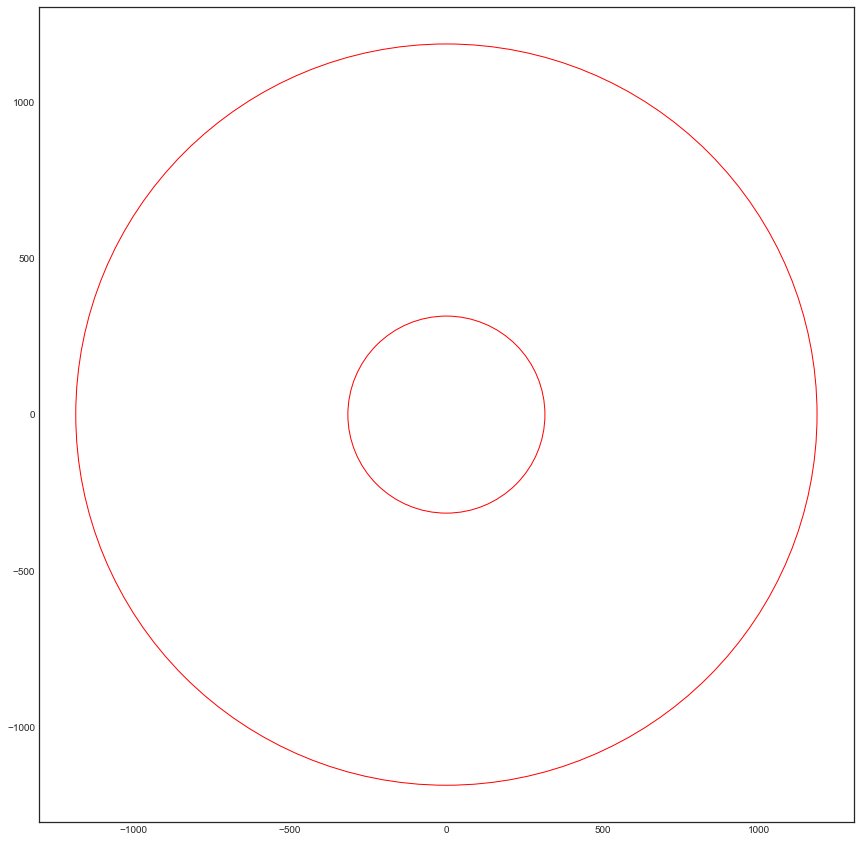

In [6]:
inner = plt.Circle((0, 0), 315,fill=None, edgecolor='r')
outer = plt.Circle((0, 0), 1185,fill=None, edgecolor='r')

plt.rcParams['figure.figsize'] = [15, 15]

plt.gca().add_patch(inner)
plt.gca().add_patch(outer)

for sm in dee.supermodules:
    for mod in sm.modules:
        for sen in mod.sensors:
            plt.gca().add_patch(sen.getPolygon())

plt.axis('scaled')
plt.show()